In [1]:
# Required Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import PolynomialFeatures
from imblearn.over_sampling import SMOTE, ADASYN
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:
#Dataset
d1=pd.read_csv("D:/Desktop/AD/AD_Dataset/Gene_expression/gene_451_last1_genes.csv")
d2=pd.read_csv("d:/Desktop/AD/AD_Dataset/DNA_methylation/dmp_last_419.csv")
data=pd.read_csv("D:/Desktop/AD/AD_Dataset/Gene_expression/GSE33000_filtered_file_orginal_AD.csv")
data1=pd.read_csv("d:/Desktop/AD/AD_Dataset/DNA_methylation/dmp_disease_status.csv")

In [3]:
data['disease_status'] = data['disease_status'].apply(lambda x: 1 if x == "Alzheimer's disease" else 0)
data1 = data1.applymap(lambda x: x.replace('"', '') if isinstance(x, str) else x)

In [4]:
# Add first and last column from AD_gene to d1
d1 = pd.concat([data.iloc[:, [0, -1]], d1], axis=1)
d2 = pd.concat([data1.iloc[:,  -1], d2], axis=1)
d2['Disease State'] = d2['Disease State'].apply(lambda x: 1 if x == "Alzheimer's disease" else 0)

In [5]:
d2['Disease State'] = d2['Disease State'].apply(lambda x: 1 if x == "Alzheimer's disease" else 0)

In [6]:
# Get the gene names from both datasets (excluding Sample)
genes_d1 = set(d1.columns)-{"Sample","disease_status"}
genes_d2 = set(d2.columns) - {"Sample"}

# Find intersection
common_genes = genes_d1.intersection(genes_d2)

# Create new DataFrames containing only intersecting genes + Sample
d1_common=d1[["Sample","disease_status"] + list(common_genes)]
d2_common=d2[["Sample","Disease State"] + list(common_genes)]


In [7]:
d2_common = d2_common.rename(columns={"Disease State": "disease_status"})

In [8]:
# Combine row-wise (stack samples)
merged_df = pd.concat([d1_common, d2_common], axis=0, ignore_index=True)

# Check result
merged_df.shape
merged_df.head()

,Sample,disease_status,SERPINA5,SLC14A1,GPRASP1,FGF13,ZCCHC12,FRMPD4,HPRT1,CNKSR2,RBM3,DDX3Y,BEX1,MS4A4A,BEX5,TMSB4Y,PAK3,RPS4Y1,SYTL4
0,GSM1423780,1,0.233161,0.127394,0.055005,0.019651,0.040549,-0.044839,0.136986,-0.020435,0.341209,-1.418092,0.081533,0.177249,-0.007898,-0.953641,-0.086508,-1.658940,-0.165616
1,GSM1423781,1,-0.295554,0.053273,0.002815,0.014815,-0.111576,-0.033920,0.047247,0.072077,0.146683,0.255052,0.142487,0.270190,-0.036374,0.232091,-0.069293,0.225559,-0.172584
2,GSM1423782,1,-0.598633,-0.582372,0.123408,0.150028,0.154966,0.145267,0.160844,0.117780,0.157258,0.254411,0.225043,-0.131901,0.135785,0.386145,0.142142,0.330395,-0.388533
3,GSM1423783,1,0.237143,0.245438,-0.047806,-0.055892,-0.135880,-0.176507,0.010585,-0.173845,0.162723,-1.470255,0.052789,0.101474,-0.010927,-1.215171,-0.251430,-1.563496,-0.087103
4,GSM1423784,1,-0.775671,0.014268,0.073264,-0.069487,-0.106902,0.087054,0.143043,0.057470,-0.196429,-1.513204,0.092603,-0.220523,0.018407,-1.320286,0.116100,-1.691422,-0.354625


In [9]:
y=merged_df.iloc[:,1]
y.shape
x=merged_df.iloc[:,2:19]

In [10]:
x

,SERPINA5,SLC14A1,GPRASP1,FGF13,ZCCHC12,FRMPD4,HPRT1,CNKSR2,RBM3,DDX3Y,BEX1,MS4A4A,BEX5,TMSB4Y,PAK3,RPS4Y1,SYTL4
0,0.233161,0.127394,0.055005,0.019651,0.040549,-0.044839,0.136986,-0.020435,0.341209,-1.418092,0.081533,0.177249,-0.007898,-0.953641,-0.086508,-1.658940,-0.165616
1,-0.295554,0.053273,0.002815,0.014815,-0.111576,-0.033920,0.047247,0.072077,0.146683,0.255052,0.142487,0.270190,-0.036374,0.232091,-0.069293,0.225559,-0.172584
2,-0.598633,-0.582372,0.123408,0.150028,0.154966,0.145267,0.160844,0.117780,0.157258,0.254411,0.225043,-0.131901,0.135785,0.386145,0.142142,0.330395,-0.388533
3,0.237143,0.245438,-0.047806,-0.055892,-0.135880,-0.176507,0.010585,-0.173845,0.162723,-1.470255,0.052789,0.101474,-0.010927,-1.215171,-0.251430,-1.563496,-0.087103
4,-0.775671,0.014268,0.073264,-0.069487,-0.106902,0.087054,0.143043,0.057470,-0.196429,-1.513204,0.092603,-0.220523,0.018407,-1.320286,0.116100,-1.691422,-0.354625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,0.406802,0.154342,-0.788910,-0.444084,-1.757846,-1.314473,-1.078059,-0.545826,-0.808145,-0.769763,-0.907693,-0.089591,-0.429961,-0.824792,0.328266,-0.904005,-0.341702
749,3.204724,0.036069,-0.734319,-0.307045,-0.691529,-1.403329,-1.478574,-0.616416,-0.847690,-0.683578,-0.919475,-3.427495,-0.392802,-0.646027,0.183643,-0.561736,-0.312581
750,-3.764702,0.083931,-1.068545,-0.460924,-1.105804,-2.002255,-1.516296,-0.769406,-0.938876,-0.783844,-0.880671,-3.881480,-0.677495,-0.604200,-0.015639,-0.558501,-0.440326
751,3.494215,0.400682,-4.111160,-3.266104,-3.788603,-4.734259,-4.634969,-3.317366,-3.100065,2.658161,-3.040330,-0.334230,-2.591065,2.217983,-2.310084,2.332619,-2.700314


In [11]:
# Handle missing values before scaling
imputer = SimpleImputer(strategy="mean")   # or "median"
X_imputed = imputer.fit_transform(x)

In [12]:
X_imputed.shape

(753, 17)

In [13]:
#RF

In [14]:
# Split into train/test set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
#Random_ Forest
rf = RandomForestClassifier(random_state=42)
# Define Grid Search Parameters
param_grid = {
    'n_estimators': [100],
    'max_depth': [ None],
    'min_samples_split': [2],
    'min_samples_leaf': [ 4],
    'bootstrap': [False]
}

# Setup GridSearch with 5-fold CV
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1,
                           scoring='accuracy',
                           verbose=2)
# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters from Grid Search:\n", grid_search.best_params_)
# Best model
best_rf = grid_search.best_estimator_
# Best parameters
print("Best Parameters from Grid Search:\n", grid_search.best_params_)
# Best model
best_rf = grid_search.best_estimator_

# Evaluate on test set
y_pred = best_rf.predict(X_test)
print("\nTest Set Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters from Grid Search:
 {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best Parameters from Grid Search:
 {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}

Test Set Accuracy: 0.9271523178807947

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.94        89
           1       0.90      0.92      0.91        62

    accuracy                           0.93       151
   macro avg       0.92      0.93      0.92       151
weighted avg       0.93      0.93      0.93       151



In [16]:
X_test

,SERPINA5,SLC14A1,GPRASP1,FGF13,ZCCHC12,FRMPD4,HPRT1,CNKSR2,RBM3,DDX3Y,BEX1,MS4A4A,BEX5,TMSB4Y,PAK3,RPS4Y1,SYTL4
359,-0.347606,-0.392016,0.130249,0.156893,0.064471,0.089915,0.181325,0.042321,0.109459,0.174469,0.207228,-0.329124,0.130036,0.179782,0.135595,0.294994,-0.272370
409,-0.543853,-0.416595,0.120527,0.120515,0.155394,0.056628,0.138948,0.108589,0.124032,0.200500,0.144950,-0.467415,0.099412,0.291438,0.137376,0.278710,-0.382892
682,0.453531,-0.032145,-0.793634,-0.499004,-0.938261,-1.302855,-1.050307,-0.806671,-1.070669,-0.931415,-1.090315,-3.640370,-0.671403,-1.010905,-0.326454,-1.015110,-0.319528
80,-0.122595,0.235154,-0.410159,-0.524183,-0.552481,-0.494582,-0.460980,-0.564861,-0.423716,0.287685,-0.320019,-0.036024,-0.535798,-0.028663,-0.561423,0.248476,0.178117
723,0.616773,-2.602561,-1.166962,-0.385709,-0.763867,-2.170198,-1.531821,-0.529030,-0.594139,-0.476136,-0.498416,1.473382,-0.547308,-0.301739,0.140803,-0.168178,-0.290527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,0.073299,0.346372,-0.612568,-0.679969,-0.699383,-0.720063,-0.676579,-0.907456,-0.765251,-1.290305,-0.622236,-0.041215,-0.748566,-0.861182,-0.967054,-1.627302,0.640725
363,-0.212409,-0.150768,0.125230,0.125423,0.238057,0.087291,0.143102,0.085342,0.152369,0.198317,0.202677,-0.247119,0.100635,0.232255,0.156469,0.272006,-0.414804
471,-3.321214,-2.690022,-0.539298,-0.355139,-1.138645,-2.130203,-1.421352,-0.675612,-0.860435,-0.530300,-0.980395,-0.334464,-0.648489,-0.802222,0.476567,-0.626623,-0.328770
214,-0.183948,0.211419,-0.512345,-0.428377,-0.538258,-0.466619,-0.401878,-0.572797,-0.439943,0.167880,-0.334843,0.478875,-0.505893,-0.166573,-0.645587,0.146676,0.623071


In [17]:
#SHAP -ANALYSIS

In [18]:
import shap
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)
# Select class 1 from the last axis
shap_class_0 = shap_values[:, :, 0]
# Create a new figure
plt.figure(figsize=(10,6))

# Draw the summary plot with show=False to prevent automatic display
shap.summary_plot(shap_class_0, X_test,show=False)

# Save the figure to your directory
plt.savefig("d:/Desktop/AD/AD_IQAC/IMAGE/shap_summary_0.png", bbox_inches='tight', dpi=300)
# Close the figure
plt.close()

In [19]:
import shap
import matplotlib.pyplot as plt

# Old API
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)

# For binary classification → use class 1 SHAP values
shap_class_1 = shap_values[:, :, 1]

# Bar plot of mean absolute SHAP values
shap.summary_plot(shap_class_1, X_test, 
                  feature_names=x.columns,  
                  show=False)
# Save the figure to your directory
plt.savefig("d:/Desktop/AD/AD_IQAC/IMAGE/shap_bar_1.png", bbox_inches='tight', dpi=300)
# Close the figure
plt.close()




In [20]:
shap_values.shape

(151, 17, 2)

In [21]:
X_test.shape

(151, 17)

In [22]:
shap_class_1.shape

(151, 17)

In [23]:

# Suppose x is your NumPy array (753, 17)
print("Original shape:", x.shape)

poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
x_poly = poly.fit_transform(X_imputed)

print("With polynomial features:", x_poly.shape)



Original shape: (753, 17)
With polynomial features: (753, 170)


In [24]:
# Drop one feature from the dataset
features = merged_df.drop(["Sample", "disease_status"], axis=1)   
feature_names = features.columns.tolist()


In [25]:
feature_names

['SERPINA5',
 'SLC14A1',
 'GPRASP1',
 'FGF13',
 'ZCCHC12',
 'FRMPD4',
 'HPRT1',
 'CNKSR2',
 'RBM3',
 'DDX3Y',
 'BEX1',
 'MS4A4A',
 'BEX5',
 'TMSB4Y',
 'PAK3',
 'RPS4Y1',
 'SYTL4']

In [26]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x_poly)

In [27]:

# 3. Handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

In [28]:
X_resampled.shape

(886, 170)

In [29]:
# Split into train/test set
X1_train, X1_test, y1_train, y1_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

In [30]:
#Random_ Forest
rf = RandomForestClassifier(random_state=42)
# Define Grid Search Parameters
param_grid = {
    'n_estimators': [100],
    'max_depth': [ None],
    'min_samples_split': [2],
    'min_samples_leaf': [ 4],
    'bootstrap': [False]
}

# Setup GridSearch with 5-fold CV
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1,
                           scoring='accuracy',
                           verbose=2)
# Fit the model
grid_search.fit(X1_train, y1_train)

# Best parameters
print("Best Parameters from Grid Search:\n", grid_search.best_params_)
# Best model
best1_rf = grid_search.best_estimator_

# Evaluate on test set
y1_pred = best1_rf.predict(X1_test)
print("\nTest Set Accuracy:", accuracy_score(y1_test, y1_pred))
print("\nClassification Report:\n", classification_report(y1_test, y1_pred))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters from Grid Search:
 {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}

Test Set Accuracy: 0.9213483146067416

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92        89
           1       0.92      0.92      0.92        89

    accuracy                           0.92       178
   macro avg       0.92      0.92      0.92       178
weighted avg       0.92      0.92      0.92       178



In [31]:
#SHAP Analysis for RF

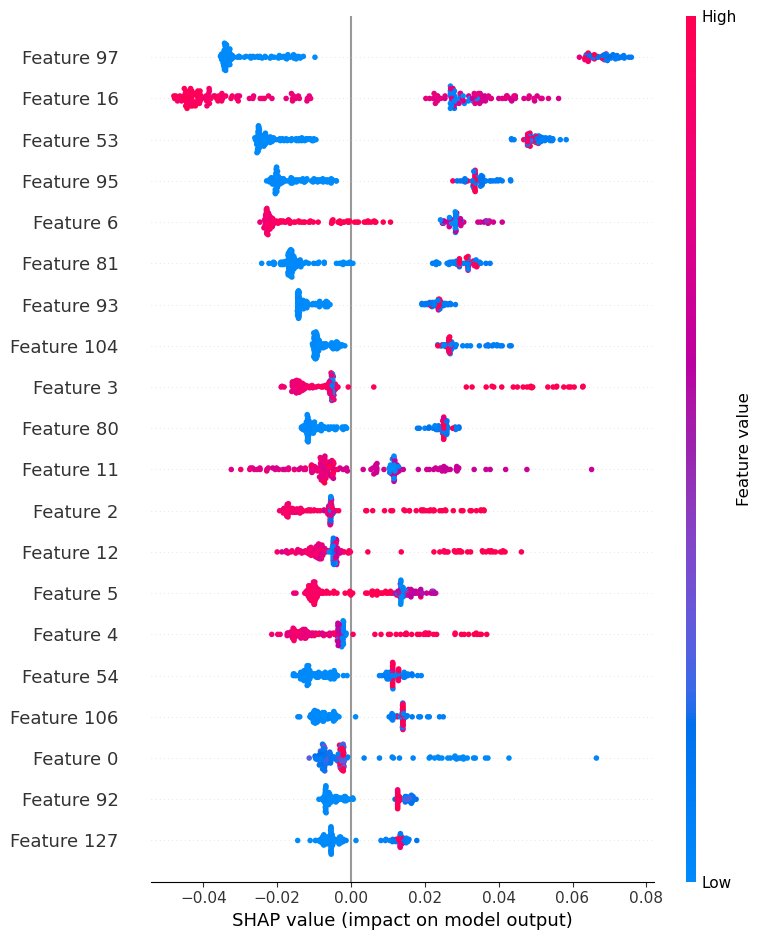

In [32]:

import shap
explainer = shap.TreeExplainer(best1_rf)
shap_values = explainer.shap_values(X1_test)
# Select class 1 from the last axis
shap_class_0 = shap_values[:, :, 0]
# Create a new figure
plt.figure(figsize=(10,6))

# Draw the summary plot with show=False to prevent automatic display
shap.summary_plot(shap_class_0, X1_test)

# Save the figure to your directory
plt.savefig("d:/Desktop/AD/AD_IQAC/IMAGE/shap_summary_0.png", bbox_inches='tight', dpi=300)
# Close the figure
plt.close()

In [33]:
# Drop one feature from the dataset
features = merged_df.drop(["Sample", "disease_status"], axis=1)   
feature_names = features.columns.tolist()



In [34]:
# Generate feature names automatically
feature_names = [f"Feature_{i+1}" for i in range(X1_test.shape[1])]

In [35]:
# Convert NumPy array to DataFrame with these feature names
X = pd.DataFrame(X1_test, columns=feature_names)

In [36]:
X.shape

(178, 170)

In [37]:
import os
# ===== SHAP Explainer =====
explainer = shap.TreeExplainer(best1_rf)
shap_values = explainer.shap_values(X)

# ===== Select a sample to visualize (class 1) =====
sample_idx = 0
expl = shap.Explanation(
    values=shap_values[1][sample_idx],
    base_values=explainer.expected_value[1],
    data=X.iloc[sample_idx],   # must be a pandas Series
    feature_names=feature_names
)

# ===== Waterfall plot for top 10 features =====
plt.figure(figsize=(10, 6))
shap.plots.waterfall(expl, max_display=10, show=False)

# ===== Save the figure =====
save_path = "d:/Desktop/AD/AD_IQAC/IMAGE/rf_shap_waterfall_top10.png" # Close the figure to free memory
plt.savefig(save_path, bbox_inches='tight', dpi=300)
plt.close()

print(f"Waterfall plot saved at: {save_path}")

Waterfall plot saved at: d:/Desktop/AD/AD_IQAC/IMAGE/rf_shap_waterfall_top10.png


In [38]:
sample_idx = 0
# For class 1 SHAP values
shap_sample_values = shap_values[1][sample_idx]  # shape: (170,)


In [39]:
expl = shap.Explanation(
    values=shap_sample_values,
    base_values=explainer.expected_value[1],
    data=X.iloc[sample_idx],      # pandas Series
    feature_names=feature_names
)


In [40]:
shap.plots.waterfall(expl, max_display=10, show=False)


<Axes: >

In [41]:
# ===== Waterfall plot for top 10 features =====
plt.figure(figsize=(10, 6))
# ===== Save the figure =====
save_path = "d:/Desktop/AD/AD_IQAC/IMAGE/shap_waterfall_top10.png"
plt.savefig(save_path, bbox_inches='tight', dpi=300)
plt.close()

print(f"Waterfall plot saved at: {save_path}")


Waterfall plot saved at: d:/Desktop/AD/AD_IQAC/IMAGE/shap_waterfall_top10.png


In [42]:
#ENSEMBLE Method
rf = RandomForestClassifier(n_estimators=300, random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
svc = SVC(probability=True, kernel="rbf", random_state=42)

# -------------------------------
# Stacking Ensemble
# -------------------------------
stack_model = StackingClassifier(
    estimators=[('rf', rf), ('xgb', xgb), ('svc', svc)],
    final_estimator=LogisticRegression(),
    cv=5
)

# -------------------------------
# Fit and evaluate
# -------------------------------
stack_model.fit(X1_train, y1_train)
y2_pred = stack_model.predict(X1_test)

print("Stacking Ensemble Accuracy:", accuracy_score(y1_test, y2_pred))
print("\nClassification Report:\n", classification_report(y1_test, y2_pred))

# -------------------------------
# Voting Classifier for comparison
# -------------------------------
voting_model = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb), ('svc', svc)],
    voting='soft'   # soft = probability average
)

voting_model.fit(X1_train, y1_train)
y2_pred_voting = voting_model.predict(X1_test)

print("Voting Ensemble Accuracy:", accuracy_score(y1_test, y2_pred_voting))


C:\Users\shaha\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [10:35:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\shaha\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [10:35:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\shaha\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [10:35:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\shaha\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [10:35:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.

Stacking Ensemble Accuracy: 0.9269662921348315

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.92      0.93        89
           1       0.92      0.93      0.93        89

    accuracy                           0.93       178
   macro avg       0.93      0.93      0.93       178
weighted avg       0.93      0.93      0.93       178



C:\Users\shaha\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [10:36:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Voting Ensemble Accuracy: 0.9325842696629213
